# ECG Anomoly Detection
Using an autoencoder to detect anomolous ECGs from a sample dataset

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 2 18:15:39 2022

@author: mafayyaz
"""

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, Conv1DTranspose, Flatten, Reshape, MaxPooling1D, Dropout
from sklearn.model_selection import train_test_split
#from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## regularization to avoid overfitting

LAMBDA_ = 0.1 #regularization

In [3]:
## DATA LOADING
#=================================================
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
dataframe.to_csv('ecg.csv',  index=False)
raw_data = dataframe.values
print(dataframe.head())

dataframe.shape

## split features (data) and outputs (labels)
# The last element contains the labels (output y)
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data (input X)
data = raw_data[:, 0:-1]

## SPLIT DTAT SET TO TRAINING / TESTING SET
#=================================================
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.15, random_state=12 #random_state=21
)

# NORMALIZATION/RESCALING
#=================================================
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

#train_data = train_data / max_val
#test_data = test_data / max_val


train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

#print('----------------------------')
#print(tf.shape(normal_train_data))
#print('----------------------------')

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

        0         1         2         3         4         5         6    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        7         8         9    ...       131       132       133       134  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

        135       136       137       138       139  140  
0  0.2577

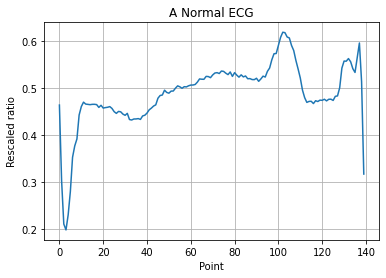

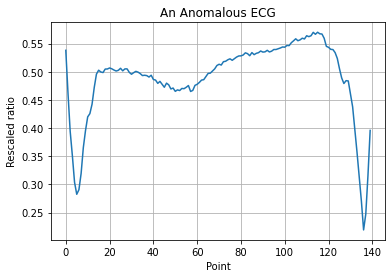

In [4]:
# PLOT OUR DATA
#=================================================
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.xlabel('Point')
plt.ylabel('Rescaled ratio')
plt.show()

plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.xlabel('Point')
plt.ylabel('Rescaled ratio')
plt.show()

Epoch 1/500
78/78 [==============================] - 2s 10ms/step - loss: 96.4623 - val_loss: 55.7381
Epoch 2/500
78/78 [==============================] - 0s 6ms/step - loss: 30.5704 - val_loss: 11.8732
Epoch 3/500
78/78 [==============================] - 0s 6ms/step - loss: 5.3856 - val_loss: 1.3713
Epoch 4/500
78/78 [==============================] - 0s 6ms/step - loss: 0.5309 - val_loss: 0.1937
Epoch 5/500
78/78 [==============================] - 0s 6ms/step - loss: 0.1829 - val_loss: 0.1812
Epoch 6/500
78/78 [==============================] - 1s 7ms/step - loss: 0.1813 - val_loss: 0.1827
Epoch 7/500
78/78 [==============================] - 0s 6ms/step - loss: 0.1813 - val_loss: 0.1821
Epoch 8/500
78/78 [==============================] - 0s 6ms/step - loss: 0.1813 - val_loss: 0.1812
Epoch 9/500
78/78 [==============================] - 0s 6ms/step - loss: 0.1812 - val_loss: 0.1819
Epoch 10/500
78/78 [==============================] - 1s 8ms/step - loss: 0.1812 - val_loss: 0.1819
Epoc

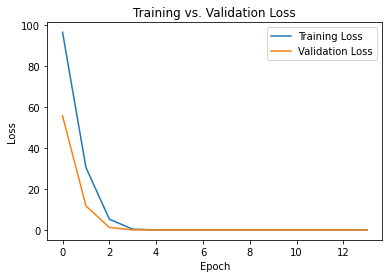

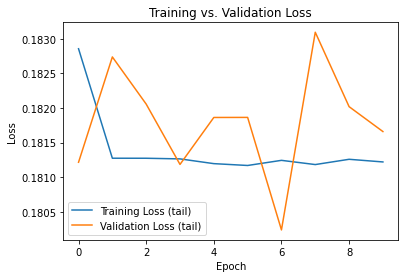

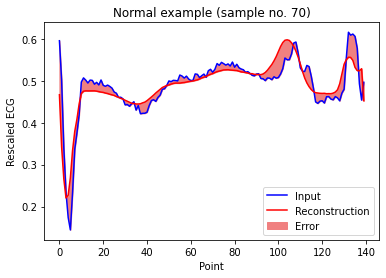

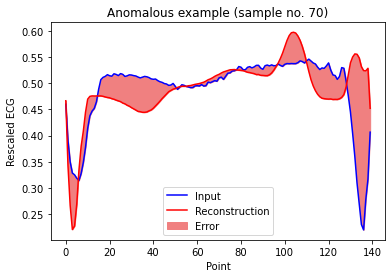

78/78 [==============================] - 1s 5ms/step


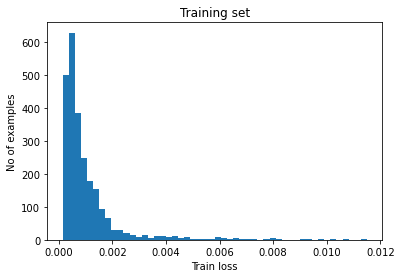

Sum train loss: 2.507209300994873
Threshold:  0.0021534553
10/10 [==============================] - 0s 3ms/step


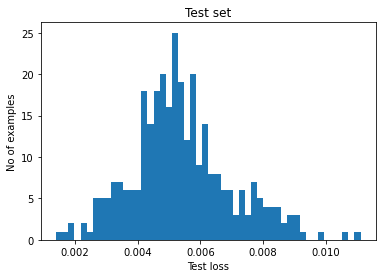

Sum test loss: 1.699743390083313
__________________________
__________________________

Accuracy = 0.9506666666666667
Precision = 0.9901477832512315
Recall = 0.9241379310344827
F1 = 0.9560047562425683

__________________________
__________________________

<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


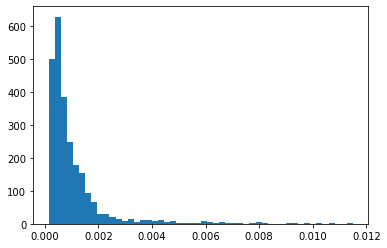

In [5]:
# MODEL DEFINITION
#=================================================

class AnomalyDetectorFullConn3(Model):
  def __init__(self):
    super(AnomalyDetectorFullConn3, self).__init__()
    self.encoder = tf.keras.Sequential([
      Dense(64, activation="relu",kernel_regularizer=tf.keras.regularizers.L1(LAMBDA_)),
      Dropout(0.2),
      Dense(32, activation="relu",kernel_regularizer=tf.keras.regularizers.L1(LAMBDA_)),
      Dropout(0.2)])

    self.decoder = tf.keras.Sequential([
      Dense(32, activation="relu",kernel_regularizer=tf.keras.regularizers.L1(LAMBDA_)),
      Dropout(0.2),
      Dense(64, activation="relu",kernel_regularizer=tf.keras.regularizers.L1(LAMBDA_)),
      Dropout(0.2),
      Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

class AnomalyDetectorOrig(Model):
  def __init__(self):
    super(AnomalyDetectorOrig, self).__init__()
    self.encoder = tf.keras.Sequential([
      Dense(128, activation="relu"),
      Dense(64, activation="relu"),
      Dense(32, activation="relu")])
      #Dense(16, activation="relu"),
      #Dense(1, activation="relu")])

    self.decoder = tf.keras.Sequential([
      #Dense(1, activation="relu"),
      Dense(32, activation="relu"),
      Dense(64, activation="relu"),
      Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# MODEL ASSIGNMENT
#=================================================

autoencoder = AnomalyDetectorFullConn3()
#autoencoder = AnomalyDetectorOrig()

#autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.compile(optimizer='adam', loss='mse')

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
    )

# MODEL TRAINING
#=================================================

history = autoencoder.fit(normal_train_data, normal_train_data, 
#history = autoencoder.fit(train_data, train_data,                           
          epochs=500, 
          #batch_size=512,
          batch_size=32,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True,
          callbacks=[callback])
'''
history = autoencoder.fit(anomalous_train_data, anomalous_train_data, 
#history = autoencoder.fit(train_data, train_data,                           
          epochs=500, 
          #batch_size=512,
          batch_size=128,
          validation_data=(anomalous_test_data, anomalous_test_data),
          shuffle=True,
          callbacks=[callback])
'''
# SHOW MODEL
#=================================================
# Display the model's architecture
print(autoencoder.summary())

# PLOT TRAINING HISTORY
#=================================================
hist_loss = history.history["loss"]
hist_val_loss = history.history["val_loss"]

plt.plot(hist_loss, label="Training Loss")
plt.plot(hist_val_loss, label="Validation Loss")
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# show the details
plt.plot(hist_loss[-10:], label="Training Loss (tail)")
plt.plot(hist_val_loss[-10:], label="Validation Loss (tail)")
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# DOING ENCODING/DECODING OF OUR TEST DATA
#=================================================
encoded_data = autoencoder.encoder(normal_test_data).numpy()
#encoded_data = autoencoder.encoder(test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

sample = 70

plt.plot(normal_test_data[sample], 'b')
plt.plot(decoded_data[sample], 'r')
#plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.fill_between(np.arange(140), decoded_data[sample], normal_test_data[sample], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title(f'Normal example (sample no. {sample})')
plt.xlabel('Point')
plt.ylabel('Rescaled ECG')
plt.show()

#encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[sample], 'b')
plt.plot(decoded_data[sample], 'r')
plt.fill_between(np.arange(140), decoded_data[sample], anomalous_test_data[sample], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title(f'Anomalous example (sample no. {sample})')
plt.xlabel('Point')
plt.ylabel('Rescaled ECG')
plt.show()

reconstructions = autoencoder.predict(normal_train_data)
#train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
train_loss = tf.keras.losses.mse(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.title('Training set')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()
print(f'Sum train loss: {np.sum(train_loss)}')

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

reconstructions = autoencoder.predict(anomalous_test_data)
#test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)
test_loss = tf.keras.losses.mse(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.title('Test set')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

print(f'Sum test loss: {np.sum(test_loss)}')

def predict(model, data, threshold):
  reconstructions = model(data)
  #loss = tf.keras.losses.mae(reconstructions, data)
  loss = tf.keras.losses.mse(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))
  print("F1 = {}".format(f1_score(labels, predictions)))


preds = predict(autoencoder, test_data, threshold)
print('__________________________\n__________________________\n')
print_stats(preds, test_labels)
print('\n__________________________\n__________________________\n')


# y_ = [1, 2] # for eg: [1, 2, 4]
# y = autoencoder # for eg: [2, 2, 4]

print(type(labels))
print(type(preds))


plt.hist(train_loss[None,:], bins=50)
plt.show()

# Re-evaluate the model
# loss, acc = autoencoder.evaluate(normal_test_data, normal_test_data, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


# confusion = tf.keras.confusion_matrix(labels=test_labels, predictions=preds, num_classes=2)


#autoencoder.save_weights('ae5_weights')
# save complete model
#autoencoder.save('saved_model/my_model_v4')
#autoencoder.save('saved_model/my_model_hds5.h5')